# Automated Zoning Map Segmentation by Pattern Recognition

**Goal**: Automatically segment zoning maps based on legend fill patterns (Residential, Local Business, Commercial & Light Manufacturing, Heavy Industrial)

**Approach**:
1. Extract legend pattern samples from the image
2. Analyze texture/pattern features (hatching density, line orientation)
3. Use pattern matching + SAM to classify and segment zones
4. Output GeoJSON with zoning classifications

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json
from typing import List, Tuple, Dict, Optional, Any
from dataclasses import dataclass, field
from scipy import ndimage
from scipy.ndimage import label as ndimage_label
from skimage.feature import local_binary_pattern
from skimage.filters import gabor_kernel
from scipy.signal import convolve2d
import torch

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 12)
plt.rcParams['figure.dpi'] = 100

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


## Define Zoning Pattern Types and Feature Extraction

In [5]:
@dataclass
class ZoningPattern:
    """Represents a zoning type and its visual pattern characteristics."""
    name: str
    description: str
    # Pattern features
    density_range: Tuple[float, float]  # (min, max) black pixel density
    line_orientation: Optional[str]  # 'horizontal', 'vertical', 'diagonal', 'cross-hatch', None
    texture_variance_range: Tuple[float, float]  # (min, max) local variance
    color: Tuple[int, int, int]  # RGB color for visualization

# Define the 4 zoning types based on typical legend patterns
ZONING_PATTERNS = {
    'residential': ZoningPattern(
        name='Residential District',
        description='Empty/white areas with minimal fill',
        density_range=(0.0, 0.15),  # Very low density - mostly white
        line_orientation=None,
        texture_variance_range=(0, 500),
        color=(144, 238, 144)  # Light green
    ),
    'local_business': ZoningPattern(
        name='Local Business',
        description='Dotted or light stipple pattern',
        density_range=(0.15, 0.35),  # Low-medium density
        line_orientation=None,
        texture_variance_range=(500, 2000),
        color=(255, 215, 0)  # Gold
    ),
    'commercial': ZoningPattern(
        name='Commercial & Light Manufacturing',
        description='Diagonal line hatching (single direction)',
        density_range=(0.25, 0.55),  # Medium density
        line_orientation='diagonal',
        texture_variance_range=(1500, 4000),
        color=(255, 165, 0)  # Orange
    ),
    'heavy_industrial': ZoningPattern(
        name='Heavy Industrial',
        description='Dense cross-hatching or solid dark fill',
        density_range=(0.45, 1.0),  # High density
        line_orientation='cross-hatch',
        texture_variance_range=(3000, 10000),
        color=(139, 0, 0)  # Dark red
    )
}

def compute_texture_features(patch: np.ndarray) -> Dict[str, float]:
    """
    Compute texture features for a small image patch.
    
    Features:
    - density: ratio of dark pixels
    - variance: local intensity variance  
    - lbp_uniformity: Local Binary Pattern uniformity (texture regularity)
    - dominant_orientation: main line direction angle
    """
    if patch.size == 0:
        return {'density': 0, 'variance': 0, 'lbp_uniformity': 0, 'orientation': 0}
    
    # Convert to grayscale if needed
    if len(patch.shape) == 3:
        gray = cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY)
    else:
        gray = patch.copy()
    
    # 1. Density - ratio of dark pixels (threshold at 200 for old maps)
    binary = (gray < 200).astype(np.float32)
    density = np.mean(binary)
    
    # 2. Variance - texture complexity
    variance = np.var(gray.astype(np.float32))
    
    # 3. Local Binary Pattern - texture uniformity
    try:
        radius = 2
        n_points = 8 * radius
        lbp = local_binary_pattern(gray, n_points, radius, method='uniform')
        hist, _ = np.histogram(lbp.ravel(), bins=n_points + 2, range=(0, n_points + 2))
        hist = hist.astype(np.float32) / (hist.sum() + 1e-6)
        lbp_uniformity = -np.sum(hist * np.log2(hist + 1e-6))  # entropy
    except:
        lbp_uniformity = 0
    
    # 4. Dominant orientation using Gabor filters
    orientation = compute_dominant_orientation(gray)
    
    return {
        'density': density,
        'variance': variance,
        'lbp_uniformity': lbp_uniformity,
        'orientation': orientation
    }

def compute_dominant_orientation(gray: np.ndarray) -> float:
    """
    Compute dominant line orientation using Gabor filters.
    Returns angle in degrees (0-180).
    """
    if gray.size < 100:
        return 0
    
    # Test multiple orientations
    angles = np.linspace(0, np.pi, 8, endpoint=False)
    responses = []
    
    for theta in angles:
        # Create Gabor kernel
        kernel = cv2.getGaborKernel(
            ksize=(21, 21),
            sigma=4.0,
            theta=theta,
            lambd=10.0,
            gamma=0.5,
            psi=0
        )
        # Apply filter
        filtered = cv2.filter2D(gray, cv2.CV_32F, kernel)
        responses.append(np.mean(np.abs(filtered)))
    
    # Find dominant orientation
    best_idx = np.argmax(responses)
    return np.degrees(angles[best_idx])

def classify_patch(features: Dict[str, float]) -> Tuple[str, float]:
    """
    Classify a patch into a zoning type based on texture features.
    Returns (zone_type, confidence).
    """
    density = features['density']
    variance = features['variance']
    orientation = features['orientation']
    
    scores = {}
    
    for zone_name, pattern in ZONING_PATTERNS.items():
        score = 0.0
        
        # Density score
        if pattern.density_range[0] <= density <= pattern.density_range[1]:
            # How centered within the range
            mid = (pattern.density_range[0] + pattern.density_range[1]) / 2
            range_size = pattern.density_range[1] - pattern.density_range[0]
            density_score = 1.0 - abs(density - mid) / (range_size / 2 + 0.01)
            score += density_score * 0.5
        
        # Variance score
        if pattern.texture_variance_range[0] <= variance <= pattern.texture_variance_range[1]:
            score += 0.3
        
        # Orientation score
        if pattern.line_orientation == 'diagonal':
            # Diagonal is around 45 or 135 degrees
            if 30 <= orientation <= 60 or 120 <= orientation <= 150:
                score += 0.2
        elif pattern.line_orientation == 'cross-hatch':
            # High variance indicates multiple directions
            if variance > 2000:
                score += 0.2
        elif pattern.line_orientation is None:
            # No strong orientation expected
            score += 0.1
        
        scores[zone_name] = score
    
    # Get best classification
    best_zone = max(scores, key=scores.get)
    confidence = scores[best_zone]
    
    return best_zone, confidence

print("✅ Pattern analysis functions defined")
print("\nZoning Types:")
for name, pattern in ZONING_PATTERNS.items():
    print(f"  {pattern.name}: density {pattern.density_range}, orientation={pattern.line_orientation}")

✅ Pattern analysis functions defined

Zoning Types:
  Residential District: density (0.0, 0.15), orientation=None
  Local Business: density (0.15, 0.35), orientation=None
  Commercial & Light Manufacturing: density (0.25, 0.55), orientation=diagonal
  Heavy Industrial: density (0.45, 1.0), orientation=cross-hatch


## Load Map and Initialize SAM 2.1

Found 1 map files
  - appleton-post-crescent-oct-24-1922-p-13_map.png

Loaded: appleton-post-crescent-oct-24-1922-p-13_map.png, shape: (3101, 3599, 4)

Loaded: appleton-post-crescent-oct-24-1922-p-13_map.png, shape: (3101, 3599, 4)


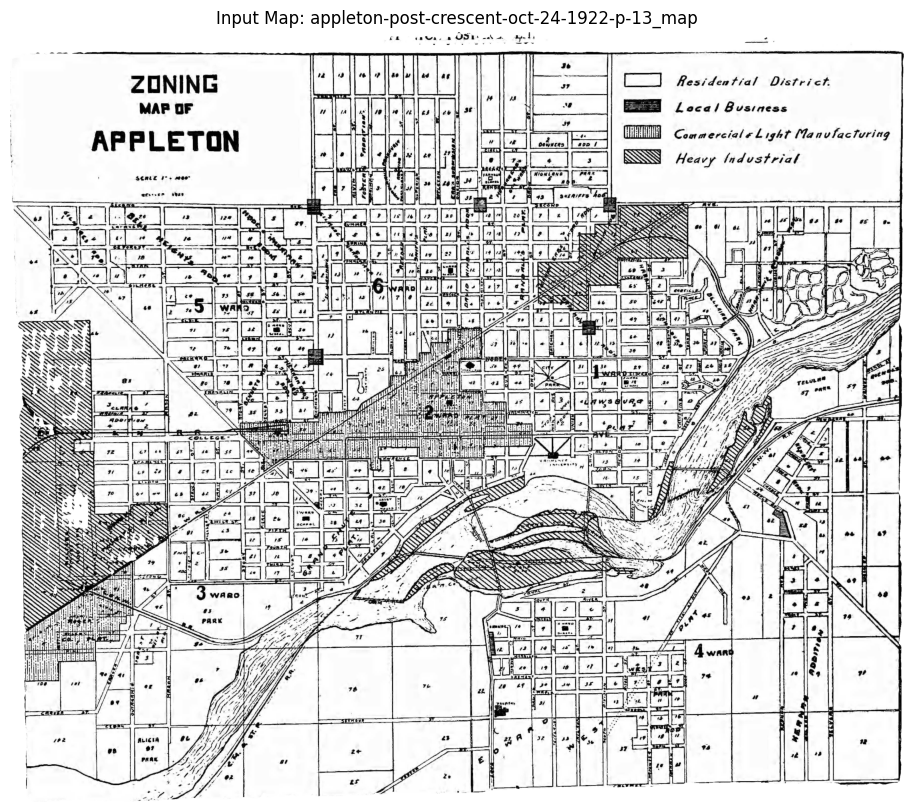

In [ ]:
# Load the Appleton map
output_dir = Path("output")
map_files = list(output_dir.glob("*appleton*_map.png"))

if not map_files:
    map_files = list(output_dir.glob("*_map.png"))

print(f"Found {len(map_files)} map files")
for f in map_files:
    print(f"  - {f.name}")

# Load the map
map_path = map_files[0]
img_raw = cv2.imread(str(map_path), cv2.IMREAD_UNCHANGED)
print(f"\nLoaded: {map_path.name}, shape: {img_raw.shape}")

# Handle alpha channel
if len(img_raw.shape) == 3 and img_raw.shape[2] == 4:
    alpha = img_raw[:, :, 3]
    rgb = img_raw[:, :, :3]
    white_bg = np.ones_like(rgb) * 255
    alpha_norm = alpha[:, :, np.newaxis] / 255.0
    img = (rgb * alpha_norm + white_bg * (1 - alpha_norm)).astype(np.uint8)
else:
    img = img_raw.copy()

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(14, 10))
plt.imshow(img_rgb)
plt.title(f"Input Map: {map_path.stem}")
plt.axis('off')
plt.show()

## Extract and Analyze Legend Patterns

Automatically detect the legend box and extract pattern samples for each zoning type.

Legend Pattern Analysis:

Residential District:
  Density: 0.000
  Variance: 0.2
  LBP Uniformity: 1.92
  Orientation: 45.0°

Local Business:
  Density: 0.000
  Variance: 4.9
  LBP Uniformity: 3.02
  Orientation: 45.0°

Commercial & Light Manufacturing:
  Density: 0.000
  Variance: 1.6
  LBP Uniformity: 2.97
  Orientation: 135.0°

Heavy Industrial:
  Density: 0.000
  Variance: 0.2
  LBP Uniformity: 1.74
  Orientation: 135.0°


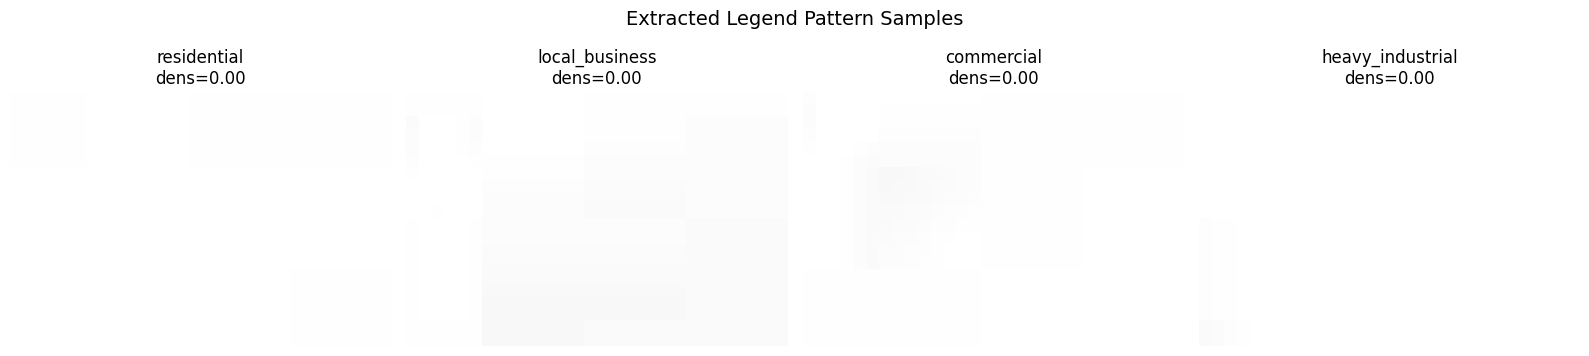

In [7]:
def find_legend_region(image: np.ndarray) -> Tuple[int, int, int, int]:
    """
    Attempt to find the legend box in the image.
    Usually in top-right or bottom-right corner.
    Returns (x, y, w, h) or None.
    """
    h, w = image.shape[:2]
    
    # For the Appleton map, legend is in top-right area
    # Search in right 40% of image, top 30%
    search_region = image[0:int(h*0.35), int(w*0.55):]
    
    gray_search = cv2.cvtColor(search_region, cv2.COLOR_BGR2GRAY) if len(search_region.shape) == 3 else search_region
    
    # Find rectangles that could be legend boxes
    edges = cv2.Canny(gray_search, 50, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Look for rectangular shapes
    for cnt in sorted(contours, key=cv2.contourArea, reverse=True)[:10]:
        x, y, cw, ch = cv2.boundingRect(cnt)
        if cw > 50 and ch > 50:  # Minimum size
            # Offset by search region position
            return (int(w*0.55) + x, y, cw, ch)
    
    return None

def extract_legend_samples_manual(image: np.ndarray) -> Dict[str, np.ndarray]:
    """
    Extract legend pattern samples based on typical legend layout.
    For Appleton map: legend is in top-right with 4 patterns stacked vertically.
    
    Returns dict mapping zone_type to sample patch.
    """
    h, w = image.shape[:2]
    
    # Legend location for Appleton map (approximate - adjust if needed)
    # The legend box appears to be roughly in the top-right
    legend_x = int(w * 0.73)  # Start x of legend pattern samples
    legend_y_start = int(h * 0.05)  # Start y
    sample_w = 30  # Width of each sample
    sample_h = 20  # Height of each sample
    spacing = 28  # Vertical spacing between samples
    
    samples = {}
    
    # Extract samples - order matches legend top to bottom
    # 1. Residential (empty box)
    samples['residential'] = image[legend_y_start:legend_y_start+sample_h, 
                                   legend_x:legend_x+sample_w].copy()
    
    # 2. Local Business (dotted)
    y2 = legend_y_start + spacing
    samples['local_business'] = image[y2:y2+sample_h, 
                                      legend_x:legend_x+sample_w].copy()
    
    # 3. Commercial (diagonal hatching)
    y3 = legend_y_start + 2*spacing
    samples['commercial'] = image[y3:y3+sample_h,
                                  legend_x:legend_x+sample_w].copy()
    
    # 4. Heavy Industrial (cross-hatching)
    y4 = legend_y_start + 3*spacing
    samples['heavy_industrial'] = image[y4:y4+sample_h,
                                        legend_x:legend_x+sample_w].copy()
    
    return samples

# Try to extract legend samples
legend_samples = extract_legend_samples_manual(img)

# Compute features for each legend sample
legend_features = {}
print("Legend Pattern Analysis:")
print("=" * 60)

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i, (zone_name, sample) in enumerate(legend_samples.items()):
    features = compute_texture_features(sample)
    legend_features[zone_name] = features
    
    pattern = ZONING_PATTERNS[zone_name]
    print(f"\n{pattern.name}:")
    print(f"  Density: {features['density']:.3f}")
    print(f"  Variance: {features['variance']:.1f}")
    print(f"  LBP Uniformity: {features['lbp_uniformity']:.2f}")
    print(f"  Orientation: {features['orientation']:.1f}°")
    
    # Display sample
    sample_rgb = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB) if len(sample.shape) == 3 else sample
    axes[i].imshow(sample_rgb, cmap='gray' if len(sample.shape) == 2 else None)
    axes[i].set_title(f"{zone_name}\ndens={features['density']:.2f}")
    axes[i].axis('off')

plt.suptitle("Extracted Legend Pattern Samples", fontsize=14)
plt.tight_layout()
plt.show()

## Create Pattern-Based Classification Map

Use sliding window to classify each region of the map based on texture similarity to legend patterns.

🔄 Classifying map regions by texture pattern...
   This may take a minute...
✅ Classification complete!
✅ Classification complete!


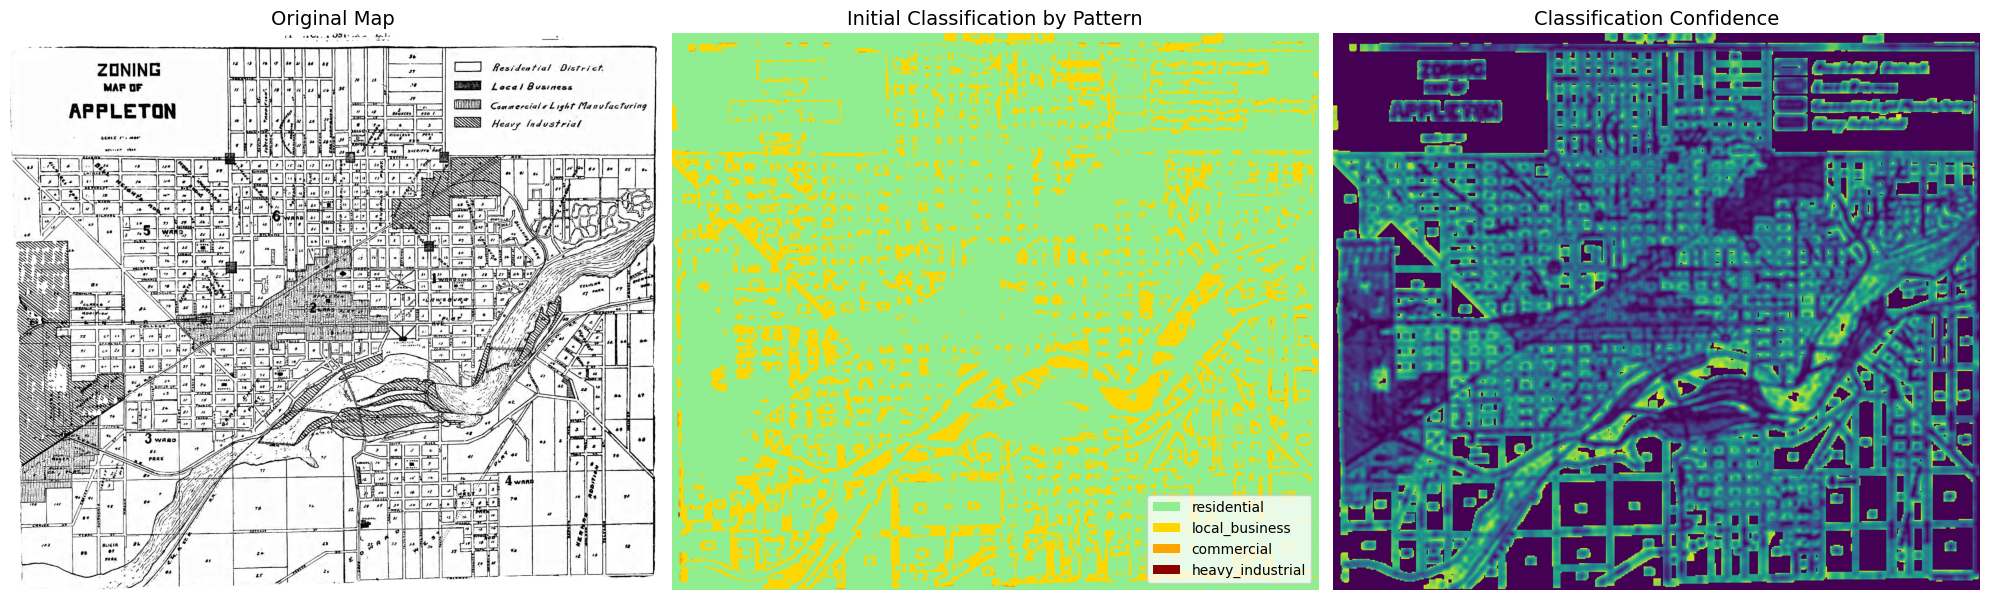

In [8]:
def compute_pattern_similarity(patch_features: Dict, legend_features: Dict[str, Dict]) -> Dict[str, float]:
    """
    Compute similarity score between a patch and each legend pattern.
    """
    scores = {}
    
    for zone_name, ref_features in legend_features.items():
        # Weighted distance in feature space
        density_diff = abs(patch_features['density'] - ref_features['density'])
        variance_diff = abs(patch_features['variance'] - ref_features['variance']) / 5000.0
        lbp_diff = abs(patch_features['lbp_uniformity'] - ref_features['lbp_uniformity']) / 3.0
        
        # Convert distance to similarity
        distance = density_diff * 0.5 + variance_diff * 0.3 + lbp_diff * 0.2
        similarity = max(0, 1.0 - distance)
        scores[zone_name] = similarity
    
    return scores

def classify_map_by_pattern(image: np.ndarray, 
                           legend_features: Dict[str, Dict],
                           window_size: int = 32,
                           stride: int = 8) -> np.ndarray:
    """
    Classify each region of the map based on texture patterns.
    
    Returns classification map where each pixel has a zone label:
    0 = residential, 1 = local_business, 2 = commercial, 3 = heavy_industrial
    """
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()
    
    h, w = gray.shape
    zone_names = list(legend_features.keys())
    
    # Create output classification map
    class_map = np.zeros((h, w), dtype=np.float32)
    confidence_map = np.zeros((h, w), dtype=np.float32)
    vote_count = np.zeros((h, w), dtype=np.float32)
    
    # Sliding window classification
    for y in range(0, h - window_size, stride):
        for x in range(0, w - window_size, stride):
            patch = gray[y:y+window_size, x:x+window_size]
            
            # Skip nearly white patches (outside map boundary)
            if np.mean(patch) > 245:
                continue
            
            # Compute features
            features = compute_texture_features(patch)
            
            # Get similarity to each pattern
            similarities = compute_pattern_similarity(features, legend_features)
            
            # Get best match
            best_zone = max(similarities, key=similarities.get)
            best_score = similarities[best_zone]
            zone_idx = zone_names.index(best_zone)
            
            # Accumulate votes
            class_map[y:y+window_size, x:x+window_size] += zone_idx * best_score
            confidence_map[y:y+window_size, x:x+window_size] += best_score
            vote_count[y:y+window_size, x:x+window_size] += 1
    
    # Average the votes
    valid = vote_count > 0
    class_map[valid] = class_map[valid] / vote_count[valid]
    confidence_map[valid] = confidence_map[valid] / vote_count[valid]
    
    # Round to nearest class
    class_map = np.round(class_map).astype(np.int32)
    
    return class_map, confidence_map, zone_names

print("🔄 Classifying map regions by texture pattern...")
print("   This may take a minute...")

# Use smaller stride for finer resolution
class_map, confidence_map, zone_names = classify_map_by_pattern(
    img, legend_features, window_size=24, stride=6
)

print("✅ Classification complete!")

# Visualize classification
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

# Original
axes[0].imshow(img_rgb)
axes[0].set_title("Original Map", fontsize=14)
axes[0].axis('off')

# Classification map
zone_colors = np.array([
    [144, 238, 144],  # residential - light green
    [255, 215, 0],    # local_business - gold
    [255, 165, 0],    # commercial - orange
    [139, 0, 0]       # heavy_industrial - dark red
]) / 255.0

colored_class = zone_colors[class_map]
axes[1].imshow(colored_class)
axes[1].set_title("Initial Classification by Pattern", fontsize=14)
axes[1].axis('off')

# Confidence
axes[2].imshow(confidence_map, cmap='viridis')
axes[2].set_title("Classification Confidence", fontsize=14)
axes[2].axis('off')

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=zone_colors[i], label=zone_names[i]) 
                   for i in range(len(zone_names))]
axes[1].legend(handles=legend_elements, loc='lower right', fontsize=10)

plt.tight_layout()
plt.show()

## Refine Classification with SAM Segmentation

Use SAM to get clean region boundaries, then assign zone type based on majority pattern within each SAM region.

In [9]:
# Initialize SAM 2.1
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

SAM2_CHECKPOINT = "sam2.1_hiera_small.pt"
SAM2_CONFIG = "configs/sam2.1/sam2.1_hiera_s.yaml"

sam2_model = build_sam2(SAM2_CONFIG, SAM2_CHECKPOINT, device=device)

# Configure for urban zoning map block detection
mask_generator = SAM2AutomaticMaskGenerator(
    model=sam2_model,
    points_per_side=48,  # More points for finer detection
    pred_iou_thresh=0.75,
    stability_score_thresh=0.90,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=300,  # Detect smaller blocks
)

print("✅ SAM 2.1 initialized for region detection")

✅ SAM 2.1 initialized for region detection


## Run SAM to Get Clean Region Boundaries

In [10]:
print("🔄 Running SAM 2.1 segmentation...")
sam_masks = mask_generator.generate(img_rgb)
print(f"✅ SAM found {len(sam_masks)} regions")

# Sort by area
sam_masks = sorted(sam_masks, key=lambda x: x['area'], reverse=True)

# Show top regions
print("\nTop 15 regions by area:")
for i, m in enumerate(sam_masks[:15]):
    print(f"  {i+1}. Area: {m['area']:,}px, IoU: {m['predicted_iou']:.3f}")

🔄 Running SAM 2.1 segmentation...


/Users/rishabh/dev/econ-research/.venv/lib/python3.14/site-packages/sam2/sam2_image_predictor.py:431: UserWarning: cannot import name '_C' from 'sam2' (/Users/rishabh/dev/econ-research/.venv/lib/python3.14/site-packages/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  masks = self._transforms.postprocess_masks(


KeyboardInterrupt: 

In [ ]:
def classify_sam_region(mask: np.ndarray, 
                        image: np.ndarray,
                        legend_features: Dict[str, Dict]) -> Tuple[str, float]:
    """
    Classify a SAM region by analyzing its interior texture.
    Returns (zone_type, confidence).
    """
    # Get masked region
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    
    # Extract pixels inside mask
    region_pixels = gray[mask]
    
    if len(region_pixels) < 100:
        return 'residential', 0.0  # Default for tiny regions
    
    # Compute region-level features
    density = np.mean(region_pixels < 200) 
    variance = np.var(region_pixels.astype(np.float32))
    
    # Compare to legend patterns
    best_zone = 'residential'
    best_score = 0.0
    
    for zone_name, ref_features in legend_features.items():
        density_diff = abs(density - ref_features['density'])
        variance_diff = abs(variance - ref_features['variance']) / 5000.0
        
        distance = density_diff * 0.6 + variance_diff * 0.4
        similarity = max(0, 1.0 - distance * 2)
        
        if similarity > best_score:
            best_score = similarity
            best_zone = zone_name
    
    return best_zone, best_score


@dataclass
class ZonedRegion:
    """A region with its zoning classification."""
    zone_type: str
    zone_name: str
    mask: np.ndarray
    contour: np.ndarray
    area: int
    confidence: float
    bbox: Tuple[int, int, int, int]
    polygon: List[Tuple[float, float]]


def extract_zoned_regions(sam_masks: List[Dict],
                         image: np.ndarray,
                         legend_features: Dict[str, Dict],
                         min_area: int = 500,
                         simplify_tolerance: float = 2.0) -> List[ZonedRegion]:
    """
    Process SAM masks and classify each region by zoning type.
    """
    regions = []
    
    for mask_data in sam_masks:
        mask = mask_data['segmentation']
        area = mask_data['area']
        
        if area < min_area:
            continue
        
        # Classify by texture
        zone_type, confidence = classify_sam_region(mask, image, legend_features)
        
        # Get contour
        mask_uint8 = mask.astype(np.uint8) * 255
        contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if not contours:
            continue
        
        contour = max(contours, key=cv2.contourArea)
        
        # Simplify
        epsilon = simplify_tolerance * cv2.arcLength(contour, True) / 100
        simplified = cv2.approxPolyDP(contour, epsilon, True)
        
        # Get bbox
        x, y, w, h = cv2.boundingRect(contour)
        
        # Convert to polygon points
        polygon = [(float(pt[0][0]), float(pt[0][1])) for pt in simplified]
        
        regions.append(ZonedRegion(
            zone_type=zone_type,
            zone_name=ZONING_PATTERNS[zone_type].name,
            mask=mask,
            contour=simplified,
            area=area,
            confidence=confidence,
            bbox=(x, y, w, h),
            polygon=polygon
        ))
    
    return regions


# Process all SAM regions
print("🔄 Classifying SAM regions by zoning type...")
zoned_regions = extract_zoned_regions(sam_masks, img, legend_features, min_area=400)
print(f"✅ Classified {len(zoned_regions)} regions")

# Count by zone type
zone_counts = {}
for r in zoned_regions:
    zone_counts[r.zone_type] = zone_counts.get(r.zone_type, 0) + 1

print("\nRegions by zoning type:")
for zone_type, count in sorted(zone_counts.items()):
    print(f"  {ZONING_PATTERNS[zone_type].name}: {count} regions")

## Visualize Classified Zoning Map

In [ ]:
def visualize_zoned_map(image: np.ndarray, 
                       regions: List[ZonedRegion],
                       alpha: float = 0.5) -> np.ndarray:
    """
    Create visualization with colored zones.
    """
    if len(image.shape) == 3 and image.shape[2] == 3:
        viz = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).copy()
    else:
        viz = image.copy()
    
    overlay = np.zeros_like(viz)
    
    # Draw filled regions
    for region in regions:
        color = ZONING_PATTERNS[region.zone_type].color
        cv2.fillPoly(overlay, [region.contour], color)
    
    # Blend
    viz = cv2.addWeighted(viz, 1-alpha, overlay, alpha, 0)
    
    # Draw contours
    for region in regions:
        color = ZONING_PATTERNS[region.zone_type].color
        cv2.drawContours(viz, [region.contour], -1, color, 2)
    
    return viz


# Create visualization
viz = visualize_zoned_map(img, zoned_regions, alpha=0.4)

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Original
axes[0].imshow(img_rgb)
axes[0].set_title("Original Zoning Map", fontsize=14)
axes[0].axis('off')

# Classified
axes[1].imshow(viz)
axes[1].set_title("SAM + Pattern Classification", fontsize=14)
axes[1].axis('off')

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=np.array(ZONING_PATTERNS[z].color)/255, 
          label=f"{ZONING_PATTERNS[z].name} ({zone_counts.get(z, 0)} regions)")
    for z in ['residential', 'local_business', 'commercial', 'heavy_industrial']
]
axes[1].legend(handles=legend_elements, loc='lower right', fontsize=11)

plt.tight_layout()
plt.show()

## Export to GeoJSON with Zoning Classifications

In [ ]:
def zoned_regions_to_geojson(regions: List[ZonedRegion], 
                             map_name: str) -> Dict:
    """
    Convert zoned regions to GeoJSON with zone classification.
    """
    features = []
    
    for i, region in enumerate(regions):
        coords = region.polygon.copy()
        
        # Close polygon
        if coords and coords[0] != coords[-1]:
            coords.append(coords[0])
        
        feature = {
            "type": "Feature",
            "properties": {
                "id": i,
                "zone_type": region.zone_type,
                "zone_name": region.zone_name,
                "area_pixels": region.area,
                "confidence": round(region.confidence, 3),
                "bbox": list(region.bbox)
            },
            "geometry": {
                "type": "Polygon",
                "coordinates": [coords]
            }
        }
        features.append(feature)
    
    return {
        "type": "FeatureCollection",
        "name": map_name,
        "properties": {
            "zone_types": {
                "residential": ZONING_PATTERNS['residential'].name,
                "local_business": ZONING_PATTERNS['local_business'].name,
                "commercial": ZONING_PATTERNS['commercial'].name,
                "heavy_industrial": ZONING_PATTERNS['heavy_industrial'].name
            }
        },
        "features": features
    }


# Create output directory
output_geojson_dir = Path("geospatial_outputs")
output_geojson_dir.mkdir(exist_ok=True)

# Export GeoJSON
map_name = map_path.stem.replace("_map", "")
geojson = zoned_regions_to_geojson(zoned_regions, map_name)

geojson_path = output_geojson_dir / f"{map_name}_zoned.geojson"
with open(geojson_path, 'w') as f:
    json.dump(geojson, f, indent=2)

print(f"✅ Exported GeoJSON: {geojson_path}")
print(f"   Total features: {len(geojson['features'])}")

# Summary by zone
print("\nFeatures by zone:")
for zone_type in ['residential', 'local_business', 'commercial', 'heavy_industrial']:
    count = sum(1 for f in geojson['features'] if f['properties']['zone_type'] == zone_type)
    print(f"  {ZONING_PATTERNS[zone_type].name}: {count}")

## Fine-Tune: Adjust Legend Sample Positions

If the automatic legend extraction didn't get the right patterns, manually adjust the sample coordinates here.

In [ ]:
# Interactive tool to find correct legend positions
# Click on the image to see coordinates

def show_legend_finder(image: np.ndarray):
    """Display image with grid to help locate legend samples."""
    h, w = image.shape[:2]
    
    fig, ax = plt.subplots(figsize=(18, 12))
    
    if len(image.shape) == 3:
        ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    else:
        ax.imshow(image, cmap='gray')
    
    # Focus on top-right where legend usually is
    ax.set_xlim([w*0.5, w])
    ax.set_ylim([h*0.4, 0])  # Flip y
    
    # Add grid
    ax.grid(True, alpha=0.3)
    ax.set_title("Legend Area - Use coordinates to adjust sample positions\n"
                 "Right-click to get (x,y) coordinates", fontsize=12)
    
    plt.tight_layout()
    plt.show()

# Show zoomed view of legend area
show_legend_finder(img)

print("\n" + "="*60)
print("INSTRUCTIONS:")
print("="*60)
print("""
If the pattern samples aren't matching correctly, update the 
extract_legend_samples_manual() function with the correct coordinates.

Current sample locations:
  legend_x = int(w * 0.73)  # X position of pattern boxes
  legend_y_start = int(h * 0.05)  # Y start
  sample_w = 30, sample_h = 20  # Sample dimensions
  spacing = 28  # Vertical spacing between samples

Look at the legend in your map and adjust these values to match
the actual pattern sample boxes next to each label.
""")